<a href="https://colab.research.google.com/github/MANISH-KUMAR-CODES/Book-Recommendtion-System/blob/main/Book_Recommendtion_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such
web services, recommender systems have taken more and more place in our lives. From
e-commerce (suggest to buyers articles that could interest them) to online advertisement
(suggest to users the right contents, matching their preferences), recommender systems are
today unavoidable in our daily online journeys.
In a very general way, recommender systems are algorithms aimed at suggesting relevant
items to users (items being movies to watch, text to read, products to buy, or anything else
depending on industries).
Recommender systems are really critical in some industries as they can generate a huge
amount of income when they are efficient or also be a way to stand out significantly from
competitors. The main objective is to create a book recommendation system for users.

Content The Book-Crossing dataset comprises 3 files.

 ● Users Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.
 
  ● Books Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website. 
  
  ● Ratings Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [3]:
# importing all the necessary files 
import re
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from scipy.spatial.distance import correlation
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

### Recommendation Systems are one of the largest application areas of Machine Learning. They enable tailoring personalized content for users, thereby generating revenue for businesses

### There are 2 main types of personalized recommendation systems:

## Content based filtering
### Recommendations are based on user's past likes/ dislikes & item feature space. The system makes recommendations which are similar to items the user has liked in the past. Items are considered similar based on item's features such as author, publisher, genre etc

## Collaborative based filtering
### Recommendations are based solely on user's past likes/ dislikes & how other users have rated other items. The system does not take into consideration an item's features like author, publisher, genre etc nor a user's features like age, gender, location etc. These take either a memory based approach or a model based approach

### **(1)Memory based approach:** Utilizes entire user-item rating information to calculate similarity scores between items or users for making recommendations. These are further either of 2 types:

  User based: Two users are considered similar, if they rate items in a similar manner. An item is recommended to a user, if another user i.e., similar to the user in question has liked the item

  Item based: Two items are considered similar, if users rate them in a similar manner. An item is recommended to a user, that is similar to the items the user has rated in the past

### **(2)Model based approach:** Utilizes user-item rating information to build a model & the model (not the entire dataset) is thereafter used for making recommendations. This approach is preferred in instances where time & scalability are a concern

This project aims to build a recommendation system based on collaborative filtering & will tackle an example of both memory based & model based algorithm

### Datasource:
This project will use the 3 different csv files provided by our almabetter team

1. User.csv = with 278858 rows and 3 columns

2. Books.csv = with 271360 rows and 8 columns

3. Ratings.csv = with  1149780 rows and 3 columns




In [4]:
user_df = pd.read_csv('/content/drive/MyDrive/Copy of Users.csv')
books_df = pd.read_csv('/content/drive/MyDrive/Copy of Books.csv')
ratings_df = pd.read_csv('/content/drive/MyDrive/Copy of Ratings.csv')

In [5]:
#Top rows of our user_df
user_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [6]:
print("shape of our user_df:",user_df.shape)
print('\n')
print('null values in user_df:')
print(user_df.isnull().sum())
print('\n')
print('checking duplicates on entire  user dataframe')
len(user_df)-len(user_df.drop_duplicates())


shape of our user_df: (278858, 3)


null values in user_df:
User-ID          0
Location         0
Age         110762
dtype: int64


checking duplicates on entire  user dataframe


0

In [7]:
#Checking info of our user_df
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


From above we conclude that our User_id column is of int type ,so we need to change it  to object type and also Age column contains lots of null values so we have to find way to treat them also

In [8]:
#Converting user_id column to object type
user_df['User-ID']= user_df['User-ID'].astype('object')

In [9]:
#Checking unique values in our Age cloumn
user_df['Age'].unique()

array([ nan,  18.,  17.,  61.,  26.,  14.,  25.,  19.,  46.,  55.,  32.,
        24.,  20.,  34.,  23.,  51.,  31.,  21.,  44.,  30.,  57.,  43.,
        37.,  41.,  54.,  42.,  50.,  39.,  53.,  47.,  36.,  28.,  35.,
        13.,  58.,  49.,  38.,  45.,  62.,  63.,  27.,  33.,  29.,  66.,
        40.,  15.,  60.,   0.,  79.,  22.,  16.,  65.,  59.,  48.,  72.,
        56.,  67.,   1.,  80.,  52.,  69.,  71.,  73.,  78.,   9.,  64.,
       103., 104.,  12.,  74.,  75., 231.,   3.,  76.,  83.,  68., 119.,
        11.,  77.,   2.,  70.,  93.,   8.,   7.,   4.,  81., 114., 230.,
       239.,  10.,   5., 148., 151.,   6., 101., 201.,  96.,  84.,  82.,
        90., 123., 244., 133.,  91., 128.,  94.,  85., 141., 110.,  97.,
       219.,  86., 124.,  92., 175., 172., 209., 212., 237.,  87., 162.,
       100., 156., 136.,  95.,  89., 106.,  99., 108., 210.,  88., 199.,
       147., 168., 132., 159., 186., 152., 102., 116., 200., 115., 226.,
       137., 207., 229., 138., 109., 105., 228., 18

From above we saw our age column contains null values as well as invalid age values ,so we will keep the valid age range of readers as 10 to 90 ,replace null values and invalid ages in the Age column with the mean of valid ages.

In [10]:
#keeping age in range of 10 to 90 and replacing null values in age with mean
user_df.loc[(user_df.Age > 90) | (user_df.Age < 5), 'Age'] = np.nan
user_df.Age = user_df.Age.fillna(user_df.Age.mean())
user_df.Age = user_df.Age.astype(np.int32)

In [11]:
#Checking unique values again
print(user_df['Age'].unique())

[34 18 17 61 26 14 25 19 46 55 32 24 20 23 51 31 21 44 30 57 43 37 41 54
 42 50 39 53 47 36 28 35 13 58 49 38 45 62 63 27 33 29 66 40 15 60 79 22
 16 65 59 48 72 56 67 80 52 69 71 73 78  9 64 12 74 75 76 83 68 11 77 70
  8  7 81 10  5  6 84 82 90 85 86 87 89 88]


In [12]:
#Checking unique  values in location column
user_df['Location'].unique()

array(['nyc, new york, usa', 'stockton, california, usa',
       'moscow, yukon territory, russia', ...,
       'sergnano, lombardia, italy', 'stranraer, n/a, united kingdom',
       'tacoma, washington, united kingdom'], dtype=object)

In [13]:
#spilliting each string  in location with the help of split()
list_of_location = user_df.Location.str.split(', ')
list_of_location

0                         [nyc, new york, usa]
1                  [stockton, california, usa]
2            [moscow, yukon territory, russia]
3                  [porto, v.n.gaia, portugal]
4         [farnborough, hants, united kingdom]
                          ...                 
278853                 [portland, oregon, usa]
278854    [tacoma, washington, united kingdom]
278855             [brampton, ontario, canada]
278856             [knoxville, tennessee, usa]
278857                  [dublin, n/a, ireland]
Name: Location, Length: 278858, dtype: object

In [14]:
city = []                      #  empty list to store city locations
state =[]                      #  empty list to store state location
country = []                   #  empty list to store country location
for i in range(0,len(list_of_location)):
    if list_of_location[i][0] == ' ' or list_of_location[i][0] == '' or list_of_location[i][0]=='n/a' or list_of_location[i][0] == ',':  #removing invalid entries too
        city.append('other')
    else:
        city.append(list_of_location[i][0].lower())  #adding city in empty city list

    if(len(list_of_location[i])<2):
        state.append('other')
        country.append('other')
    else:
        if list_of_location[i][1] == ' ' or list_of_location[i][1] == '' or list_of_location[i][1]=='n/a' or list_of_location[i][1] == ',':   #removing invalid entries 
            state.append('other')          
        else:
            state.append(list_of_location[i][1].lower())   #adding state in empty city list

    if(len(list_of_location[i])<3):
            country.append('other')
    else:
         if list_of_location[i][2] == ''or list_of_location[i][1] == ',' or list_of_location[i][2] == ' ' or list_of_location[i][2] == 'n/a':
                country.append('other')
         else:
              country.append(list_of_location[i][2].lower())     #adding country in empty city list

user_df = user_df.drop('Location',axis=1)

temp = []
for ent in city:
    c = ent.split('/')            #handling cases where city/state entries from city list as state is already given 
    temp.append(c[0])                     
        

In [15]:
df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

user_df = pd.concat([user_df, df_city], axis=1)
user_df = pd.concat([user_df, df_state], axis=1)
user_df = pd.concat([user_df, df_country], axis=1)

In [16]:
## Drop duplicate rows
user_df.drop_duplicates(keep='last', inplace=True)
user_df.reset_index(drop=True, inplace=True)

In [17]:
# checking our user_df again
user_df.head()

,User-ID,Age,City,State,Country
0,1,34.0,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,34.0,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,34.0,farnborough,hants,united kingdom


## Data Processing on books_df

In [18]:
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [19]:
print("shape of our books_df:",books_df.shape)
print('\n')
print('null values in books_df:')
print(books_df.isnull().sum())
print('\n')
print('checking duplicates on entire dataframe')
len(books_df)-len(books_df.drop_duplicates())

shape of our books_df: (271360, 8)


null values in books_df:
ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


checking duplicates on entire dataframe


0

In [20]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [21]:
books_df['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [22]:
books_df[books_df['Year-Of-Publication']=='DK Publishing Inc']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [23]:
books_df[books_df['Year-Of-Publication']=='Gallimard']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


### we are dropping all these rows with mismatch values and columns with url link for each book for simplicity of our analysis

In [24]:
books_df = books_df.drop([209538,221678,220731], axis = 0).drop(['Image-URL-S','Image-URL-M','Image-URL-L'],axis = 1)

In [25]:
books_df.shape

(271357, 5)

In [26]:
## Converting year of publication in Numbers
books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype(int)

In [27]:
books_df['Year-Of-Publication'].value_counts()

2002    17627
1999    17431
2001    17359
2000    17232
1998    15766
        ...  
1910        1
1934        1
1914        1
1904        1
2037        1
Name: Year-Of-Publication, Length: 116, dtype: int64

In [28]:
#replace all rows where year=0 in year of publication with the year of max values
books_df['Year-Of-Publication']=books_df['Year-Of-Publication'].replace(0,2002)

In [29]:
books_df['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011, 1925,
       1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030, 1911,
       1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934, 1910,
       1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901, 2010,
       1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378, 1919,
       1922, 1897, 2024, 1376, 2037])

### we can see there are many invalid unique years present in our dataframe, we will try to remove them to get valid years only

In [30]:
books_df = books_df[(books_df['Year-Of-Publication']>1900) & (books_df['Year-Of-Publication']<2022)]
#checking top rows
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [31]:
#Checking info
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271337 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271337 non-null  object
 1   Book-Title           271337 non-null  object
 2   Book-Author          271336 non-null  object
 3   Year-Of-Publication  271337 non-null  int64 
 4   Publisher            271335 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.4+ MB


### Data Processing on Rating dataframe

In [32]:
#checking top rows
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [33]:
#various outputs
print("shape of our ratings_df:",ratings_df.shape)
print('\n')
print('null values in ratings_df:')
print(ratings_df.isnull().sum())
print('\n')
print('checking duplicates on entire dataframe')
len(ratings_df)-len(ratings_df.drop_duplicates())

shape of our ratings_df: (1149780, 3)


null values in ratings_df:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


checking duplicates on entire dataframe


0

In [34]:
#converting user-id into object type
ratings_df['User-ID']=ratings_df['User-ID'].astype(object)

In [35]:
#ratings df information
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  object
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 26.3+ MB


# Merging all three dataframes

In [36]:
#merging all dataframes
df = pd.merge(ratings_df , books_df, on='ISBN', how='inner')
df = pd.merge(user_df,df, on='User-ID', how='inner')
#checking first few rows
df.head()

,User-ID,Age,City,State,Country,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,2,18.0,stockton,california,usa,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,8,34.0,timmins,ontario,canada,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,8,34.0,timmins,ontario,canada,0060973129,0,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,8,34.0,timmins,ontario,canada,0374157065,0,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,8,34.0,timmins,ontario,canada,0393045218,0,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [37]:
#checking info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031070 entries, 0 to 1031069
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1031070 non-null  object 
 1   Age                  1031070 non-null  float64
 2   City                 1031070 non-null  object 
 3   State                1031070 non-null  object 
 4   Country              1031070 non-null  object 
 5   ISBN                 1031070 non-null  object 
 6   Book-Rating          1031070 non-null  int64  
 7   Book-Title           1031070 non-null  object 
 8   Book-Author          1031069 non-null  object 
 9   Year-Of-Publication  1031070 non-null  int64  
 10  Publisher            1031068 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 94.4+ MB


In [39]:
# checking description
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1031070.0,36.211543,10.354539,5.0,31.0,34.0,41.0,90.0
Book-Rating,1031070.0,2.839023,3.854151,0.0,0.0,0.0,7.0,10.0
Year-Of-Publication,1031070.0,1995.394023,7.293422,1901.0,1992.0,1997.0,2001.0,2021.0


In [42]:
#checking null
df.isnull().sum()

User-ID                0
Age                    0
City                   0
State                  0
Country                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

There are still some null values present in book-author and publisher,lets drop them

In [43]:
# dropping null values
df=df.dropna()
df.isnull().sum()

User-ID                0
Age                    0
City                   0
State                  0
Country                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

## EDA: Exploratory Data Analysis
Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

### Distribution of Year 

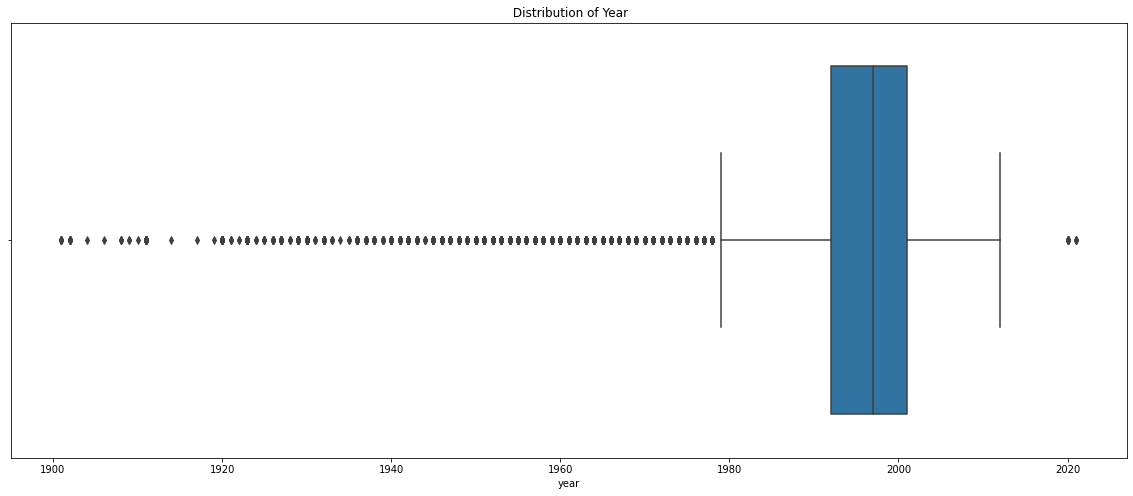

In [ ]:
# plotting Box plot 
plt.figure(figsize = (20,8))
sns.boxplot(df['Year-Of-Publication'],data = df)
plt.title(' Distribution of Year')
plt.xlabel('year')
plt.show();

### Distribution of Age